# Análise Preditiva de Acesso a Recursos (Amazon) - Equipe 2

## CRISP-DM Fase 2: Data Understanding (Compreensão dos Dados)

### Objetivo
Realizar uma análise exploratória dos dados de acesso a recursos da Amazon para desenvolver um modelo preditivo que determine se um funcionário deve ou não ter acesso a determinados recursos.

### Informações do Dataset
- **Fonte**: Amazon Employee Access Challenge
- **Problema**: Classificação binária (0 = Acesso Negado, 1 = Acesso Permitido)
- **Dados de Treinamento**: 32.769 registros
- **Abordagem**: Análise exploratória apenas nos dados de treino para evitar data leakage

## 📋 Sumário da Análise

### **Estrutura do Notebook:**
- **0. Configurações Iniciais** - Importação de bibliotecas e configurações
- **1. Carregamento e Visualização dos Dados** - Carregamento e primeira visualização
- **2. Verificação da Qualidade dos Dados** - Valores ausentes, duplicados e tipos de dados
- **3. Análise Exploratória dos Dados (EDA)** - Estatísticas, visualizações e padrões
- **4. Considerações Finais** - Conclusões e próximos passos

---

## 0. Configurações Iniciais

### 0.1 Importação de Bibliotecas e Configurações

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Carregamento e Visualização dos Dados

Nesta seção, realizamos o carregamento dos dados de treinamento e fazemos uma primeira visualização da estrutura do dataset.

In [2]:
# Carregamento dos dados de treinamento
train_df = pd.read_csv('data/train.csv')


### 1.1 Carregamento dos Dados

In [3]:
# Visualização do head de treino
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## 2. Verificação da Qualidade dos Dados

Antes de qualquer análise exploratória, é fundamental verificar a qualidade dos dados para identificar possíveis problemas como valores ausentes, duplicados ou inconsistências que possam afetar a análise.

### 2.1 Estrutura Geral do Dataset

In [34]:
# Análise da estrutura dos dados
print("=== INFORMAÇÕES GERAIS - DATASET DE TREINAMENTO ===")
print(f"Dimensões: {train_df.shape}")
print(f"Tipos de dados:\n{train_df.dtypes}")
print(f"Memória utilizada: {train_df.memory_usage().sum() / 1024**2:.2f} MB")

# Informações sobre as colunas
print("\n=== ESTRUTURA DO DATASET ===")
print(f"Colunas disponíveis: {list(train_df.columns)}")
print(f"Número total de colunas: {len(train_df.columns)}")
print(f"Número de variáveis preditoras: {len(train_df.columns) - 1}")

# Separar variáveis preditoras e target
features = [col for col in train_df.columns if col != 'ACTION']
target = 'ACTION'

print(f"\nVariável target: {target}")
print(f"Variáveis preditoras: {features}")

=== INFORMAÇÕES GERAIS - DATASET DE TREINAMENTO ===
Dimensões: (32769, 10)
Tipos de dados:
ACTION              int64
RESOURCE            int64
MGR_ID              int64
ROLE_ROLLUP_1       int64
ROLE_ROLLUP_2       int64
ROLE_DEPTNAME       int64
ROLE_TITLE          int64
ROLE_FAMILY_DESC    int64
ROLE_FAMILY         int64
ROLE_CODE           int64
dtype: object
Memória utilizada: 2.50 MB

=== ESTRUTURA DO DATASET ===
Colunas disponíveis: ['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']
Número total de colunas: 10
Número de variáveis preditoras: 9

Variável target: ACTION
Variáveis preditoras: ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


### 2.2 Verificação de Valores Ausentes e Duplicados

In [32]:
# Verificação básica da qualidade dos dados
print("=== VERIFICAÇÃO BÁSICA DA QUALIDADE DOS DADOS ===")

# Verificação de valores ausentes
print("\n=== VALORES AUSENTES ===")
missing_values = train_df.isnull().sum()
total_missing = missing_values.sum()

if total_missing == 0:
    print("✅ Nenhum valor ausente encontrado!")
else:
    print(f"⚠️  Total de valores ausentes: {total_missing}")
    print("\nPor variável:")
    for col, missing in missing_values.items():
        if missing > 0:
            percentage = (missing / len(train_df)) * 100
            print(f"  {col}: {missing} ({percentage:.2f}%)")

# Verificação de valores nulos/duplicados
print("\n=== VALORES DUPLICADOS ===")
duplicates = train_df.duplicated().sum()
if duplicates == 0:
    print("✅ Nenhum registro duplicado encontrado!")
else:
    print(f"⚠️  {duplicates} registros duplicados encontrados")

# Resumo geral
print(f"\n=== RESUMO GERAL ===")
print(f"📊 Total de registros: {len(train_df):,}")
print(f"📊 Total de variáveis: {len(train_df.columns)}")
print(f"📊 Valores ausentes: {total_missing}")
print(f"📊 Registros duplicados: {duplicates}")

if total_missing == 0 and duplicates == 0:
    print("\n✅ Dados prontos para análise!")
else:
    print("\n⚠️  Dados requerem limpeza antes da modelagem")

=== VERIFICAÇÃO BÁSICA DA QUALIDADE DOS DADOS ===

=== VALORES AUSENTES ===
✅ Nenhum valor ausente encontrado!

=== VALORES DUPLICADOS ===
✅ Nenhum registro duplicado encontrado!

=== RESUMO GERAL ===
📊 Total de registros: 32,769
📊 Total de variáveis: 10
📊 Valores ausentes: 0
📊 Registros duplicados: 0

✅ Dados prontos para análise!


### 2.3 Análise de Tipos de Dados e contagem de valores únicos

In [33]:
# Verificação dos tipos de dados e valores únicos
print("\n=== TIPOS DE DADOS E VALORES ÚNICOS ===")

# Informações dos tipos de dados
print("Tipos de dados:")
for col in train_df.columns:
    dtype = train_df[col].dtype
    unique_count = train_df[col].nunique()
    print(f"  {col}: {dtype} ({unique_count} valores únicos)")

# Verificação específica da variável target
print(f"\n=== VARIÁVEL TARGET (ACTION) ===")
target_counts = train_df['ACTION'].value_counts()
print(f"Distribuição da variável target:")
for value, count in target_counts.items():
    percentage = (count / len(train_df)) * 100
    print(f"  {value}: {count} ({percentage:.2f}%)")

# Verificação de balanceamento
minority_class = target_counts.min()
majority_class = target_counts.max()
imbalance_ratio = minority_class / majority_class
print(f"\nRazão de balanceamento: {imbalance_ratio:.3f}")

if imbalance_ratio < 0.3:
    print("⚠️  Dataset desbalanceado - considerar técnicas de balanceamento")
else:
    print("✅ Dataset razoavelmente balanceado")


=== TIPOS DE DADOS E VALORES ÚNICOS ===
Tipos de dados:
  ACTION: int64 (2 valores únicos)
  RESOURCE: int64 (7518 valores únicos)
  MGR_ID: int64 (4243 valores únicos)
  ROLE_ROLLUP_1: int64 (128 valores únicos)
  ROLE_ROLLUP_2: int64 (177 valores únicos)
  ROLE_DEPTNAME: int64 (449 valores únicos)
  ROLE_TITLE: int64 (343 valores únicos)
  ROLE_FAMILY_DESC: int64 (2358 valores únicos)
  ROLE_FAMILY: int64 (67 valores únicos)
  ROLE_CODE: int64 (343 valores únicos)

=== VARIÁVEL TARGET (ACTION) ===
Distribuição da variável target:
  1: 30872 (94.21%)
  0: 1897 (5.79%)

Razão de balanceamento: 0.061
⚠️  Dataset desbalanceado - considerar técnicas de balanceamento


## 3. Análise Exploratória dos Dados 
Agora que verificamos a qualidade dos dados, vamos realizar uma análise exploratória detalhada das características do dataset, incluindo análise estatística, visualizações e identificação de padrões.

### 3.1 Estatísticas Descritivas e Análise da Variável Target

In [5]:
# Análise estatística básica das variáveis numéricas
print("\n=== ESTATÍSTICAS DESCRITIVAS - DATASET DE TREINAMENTO ===")
print(train_df.describe())

# Análise da variável target
print("\n=== ANÁLISE DA VARIÁVEL TARGET (ACTION) ===")
target_counts = train_df['ACTION'].value_counts()
target_props = train_df['ACTION'].value_counts(normalize=True)

print(f"Distribuição da variável target:")
for i, (count, prop) in enumerate(zip(target_counts, target_props)):
    print(f"  Classe {target_counts.index[i]}: {count} ({prop:.2%})")

print(f"\nBalanceamento das classes:")
print(f"  Diferença: {abs(target_props.iloc[0] - target_props.iloc[1]):.2%}")
if abs(target_props.iloc[0] - target_props.iloc[1]) > 0.1:
    print("  ⚠️  Dataset desbalanceado!")
else:
    print("  ✅ Dataset balanceado")


=== ESTATÍSTICAS DESCRITIVAS - DATASET DE TREINAMENTO ===
             ACTION       RESOURCE         MGR_ID  ROLE_ROLLUP_1  \
count  32769.000000   32769.000000   32769.000000   32769.000000   
mean       0.942110   42923.916171   25988.957979  116952.627788   
std        0.233539   34173.892702   35928.031650   10875.563591   
min        0.000000       0.000000      25.000000    4292.000000   
25%        1.000000   20299.000000    4566.000000  117961.000000   
50%        1.000000   35376.000000   13545.000000  117961.000000   
75%        1.000000   74189.000000   42034.000000  117961.000000   
max        1.000000  312153.000000  311696.000000  311178.000000   

       ROLE_ROLLUP_2  ROLE_DEPTNAME     ROLE_TITLE  ROLE_FAMILY_DESC  \
count   32769.000000   32769.000000   32769.000000      32769.000000   
mean   118301.823156  118912.779914  125916.152644     170178.369648   
std      4551.588572   18961.322917   31036.465825      69509.462130   
min     23779.000000    4674.000000  117

### 3.3 Análise Individual da proporção da variável target

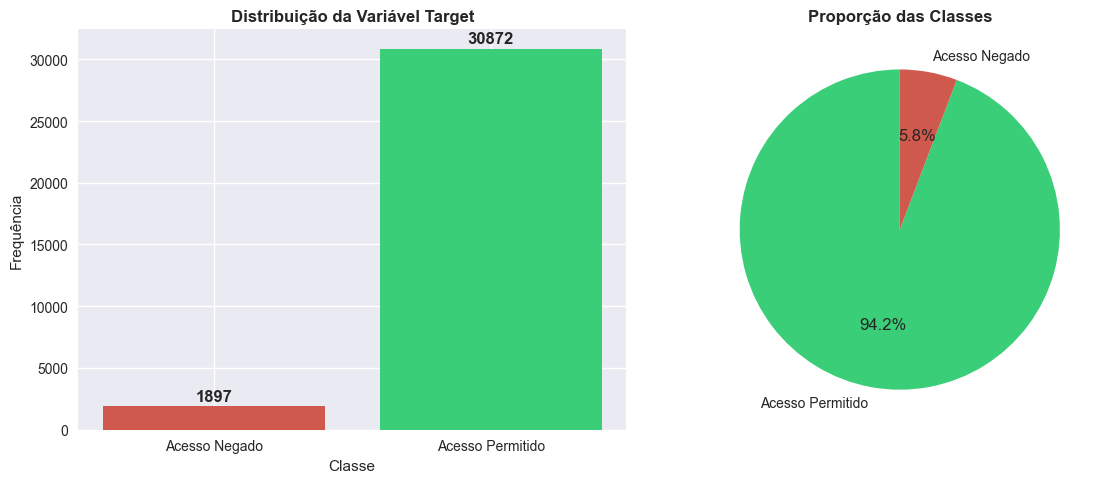

In [6]:
# Análise univariada das variáveis categóricas
categorical_vars = [col for col in train_df.columns if col != 'ACTION']

# Visualização da distribuição da variável target
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Definir cores intuitivas: vermelho para negado, verde para permitido
colors = ["#3ACE78", "#CE594C"]  # Verde e Vermelho (invertido para barras)

# Gráfico de barras
target_counts = train_df['ACTION'].value_counts()
bars = axes[0].bar(target_counts.index, target_counts.values, color=colors)
axes[0].set_title('Distribuição da Variável Target', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Frequência')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Acesso Negado', 'Acesso Permitido'])

# Adicionar valores nas barras
for bar, count in zip(bars, target_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 200,
                f'{count}', ha='center', va='bottom', fontweight='bold')

# Gráfico de pizza
axes[1].pie(target_counts.values, 
            labels=['Acesso Permitido','Acesso Negado'], 
            autopct='%1.1f%%', colors=colors,
            startangle=90)
axes[1].set_title('Proporção das Classes', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


### 3.4 Análise Número de Categorias por Feature

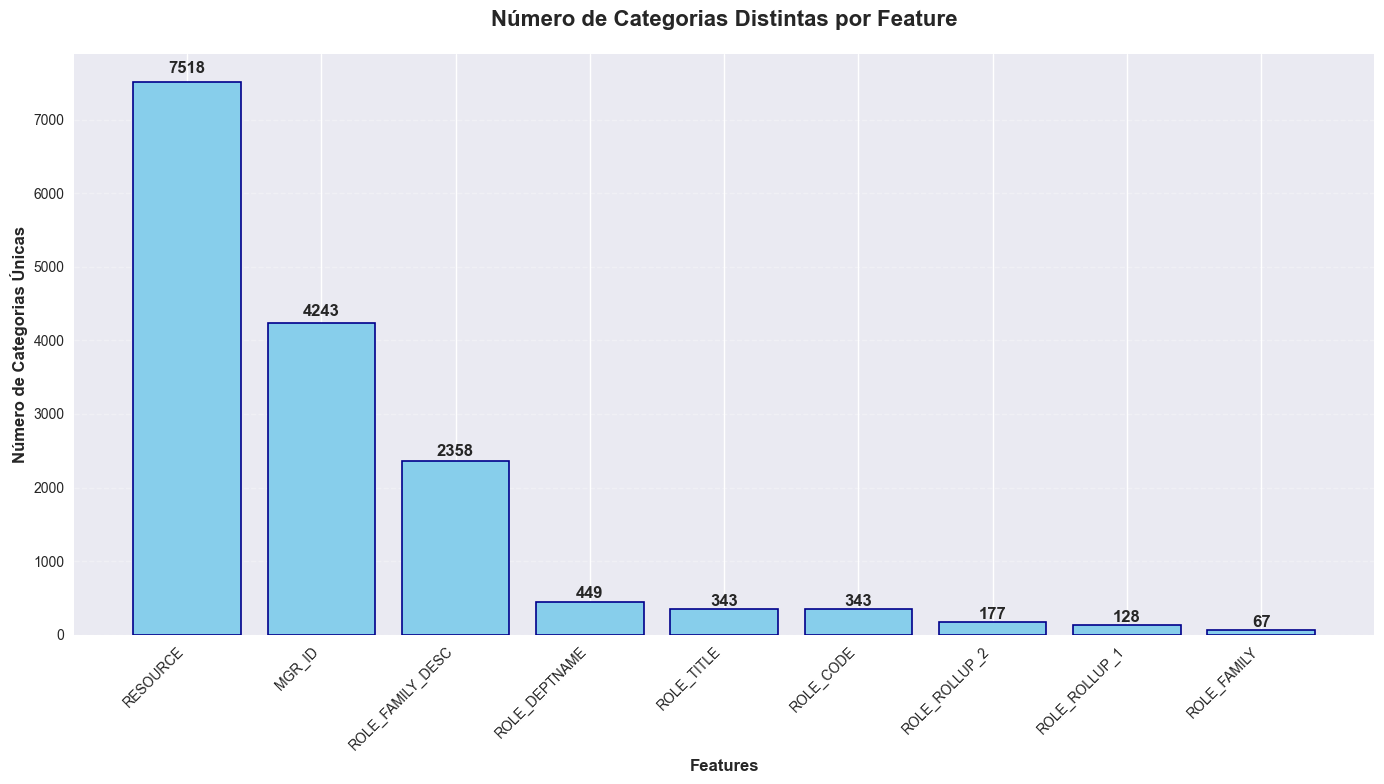


=== ESTATÍSTICAS DE CARDINALIDADE ===
Feature com maior cardinalidade: RESOURCE (7518 categorias)
Feature com menor cardinalidade: ROLE_FAMILY (67 categorias)
Cardinalidade média: 1736.2
Cardinalidade mediana: 343.0


In [36]:
# Calcular o número de categorias únicas para cada feature (excluindo ACTION)
features = [col for col in train_df.columns if col != 'ACTION']
cardinality_data = []

for feature in features:
    unique_count = train_df[feature].nunique()
    cardinality_data.append({'Feature': feature, 'Categorias_Unicas': unique_count})

# Criar DataFrame para facilitar a visualização
cardinality_df = pd.DataFrame(cardinality_data)
cardinality_df = cardinality_df.sort_values('Categorias_Unicas', ascending=False)

# Criar o gráfico de barras
plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(cardinality_df)), cardinality_df['Categorias_Unicas'], 
               color='skyblue', edgecolor='darkblue', linewidth=1.2)

# Personalizar o gráfico
plt.title('Número de Categorias Distintas por Feature', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Número de Categorias Únicas', fontsize=12, fontweight='bold')
plt.xticks(range(len(cardinality_df)), cardinality_df['Feature'], rotation=45, ha='right')

# Adicionar valores no topo de cada barra
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Adicionar grid para melhor visualização
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Ajustar layout
plt.tight_layout()
plt.show()

# Exibir estatísticas resumidas
print(f"\n=== ESTATÍSTICAS DE CARDINALIDADE ===")
print(f"Feature com maior cardinalidade: {cardinality_df.iloc[0]['Feature']} ({cardinality_df.iloc[0]['Categorias_Unicas']} categorias)")
print(f"Feature com menor cardinalidade: {cardinality_df.iloc[-1]['Feature']} ({cardinality_df.iloc[-1]['Categorias_Unicas']} categorias)")
print(f"Cardinalidade média: {cardinality_df['Categorias_Unicas'].mean():.1f}")
print(f"Cardinalidade mediana: {cardinality_df['Categorias_Unicas'].median():.1f}")

### 3.5 Análise bivariada - Relação entre variáveis preditoras e target

=== ANÁLISE BIVARIADA - VARIÁVEIS vs TARGET ===

=== ROLE_ROLLUP_1 ===
Taxa de aprovação por ROLE_ROLLUP_1 (Top 10 mais frequentes):
  117961.0: 94.9% (21407.0 solicitações)
  117902.0: 96.2% (742.0 solicitações)
  91261.0: 96.4% (721.0 solicitações)
  118315.0: 95.2% (498.0 solicitações)
  118212.0: 96.2% (400.0 solicitações)
  118290.0: 88.9% (398.0 solicitações)
  119062.0: 86.7% (375.0 solicitações)
  118887.0: 95.2% (334.0 solicitações)
  117916.0: 92.5% (295.0 solicitações)
  118169.0: 90.0% (291.0 solicitações)


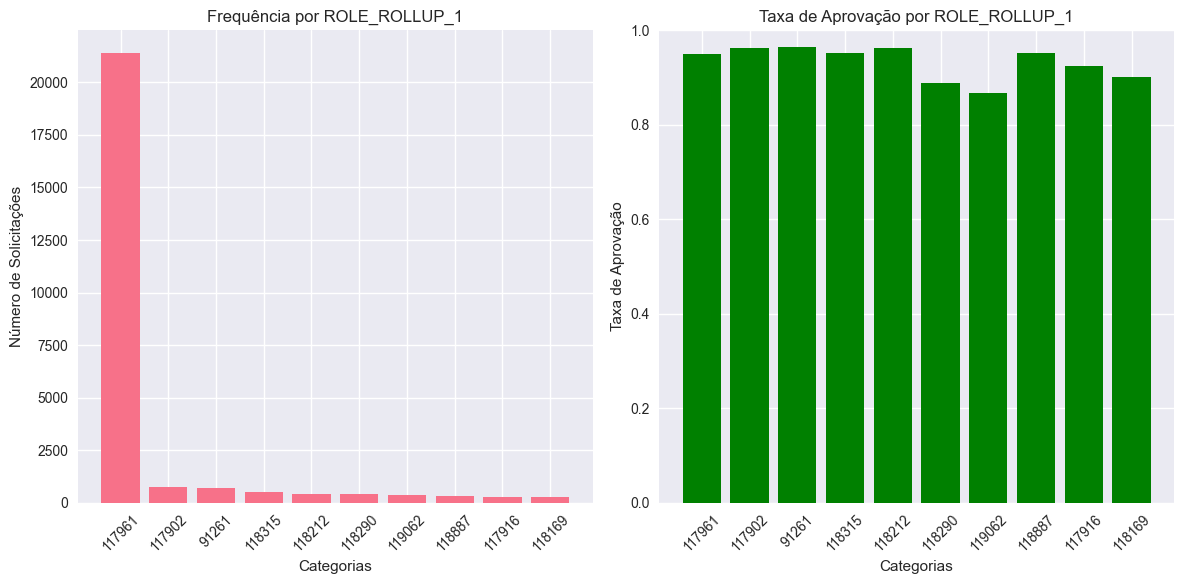


=== ROLE_ROLLUP_2 ===
Taxa de aprovação por ROLE_ROLLUP_2 (Top 10 mais frequentes):
  118300.0: 95.6% (4424.0 solicitações)
  118343.0: 96.9% (3945.0 solicitações)
  118327.0: 95.5% (2641.0 solicitações)
  118225.0: 95.7% (2547.0 solicitações)
  118386.0: 91.3% (1796.0 solicitações)
  118052.0: 88.9% (1665.0 solicitações)
  117962.0: 95.0% (1567.0 solicitações)
  118413.0: 96.4% (1295.0 solicitações)
  118446.0: 96.8% (971.0 solicitações)
  118026.0: 96.4% (721.0 solicitações)


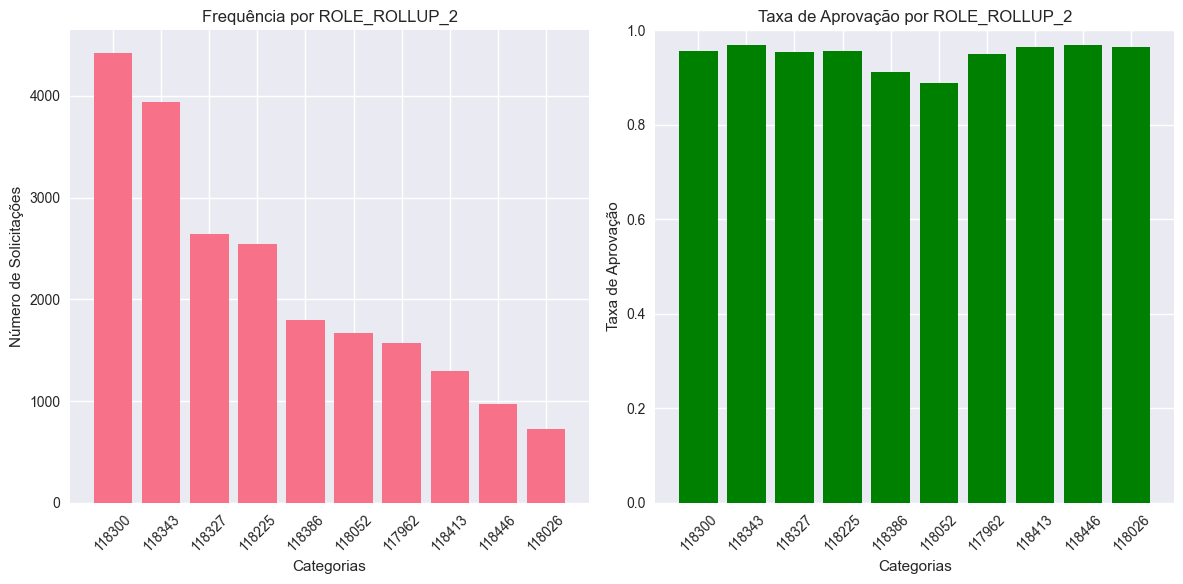


=== ROLE_DEPTNAME ===
Taxa de aprovação por ROLE_DEPTNAME (Top 10 mais frequentes):
  117878.0: 93.7% (1135.0 solicitações)
  117941.0: 91.7% (763.0 solicitações)
  117945.0: 86.5% (659.0 solicitações)
  118514.0: 98.0% (601.0 solicitações)
  117920.0: 90.6% (597.0 solicitações)
  117884.0: 92.3% (546.0 solicitações)
  119598.0: 97.8% (543.0 solicitações)
  118403.0: 97.9% (532.0 solicitações)
  119181.0: 96.4% (525.0 solicitações)
  120722.0: 97.4% (501.0 solicitações)


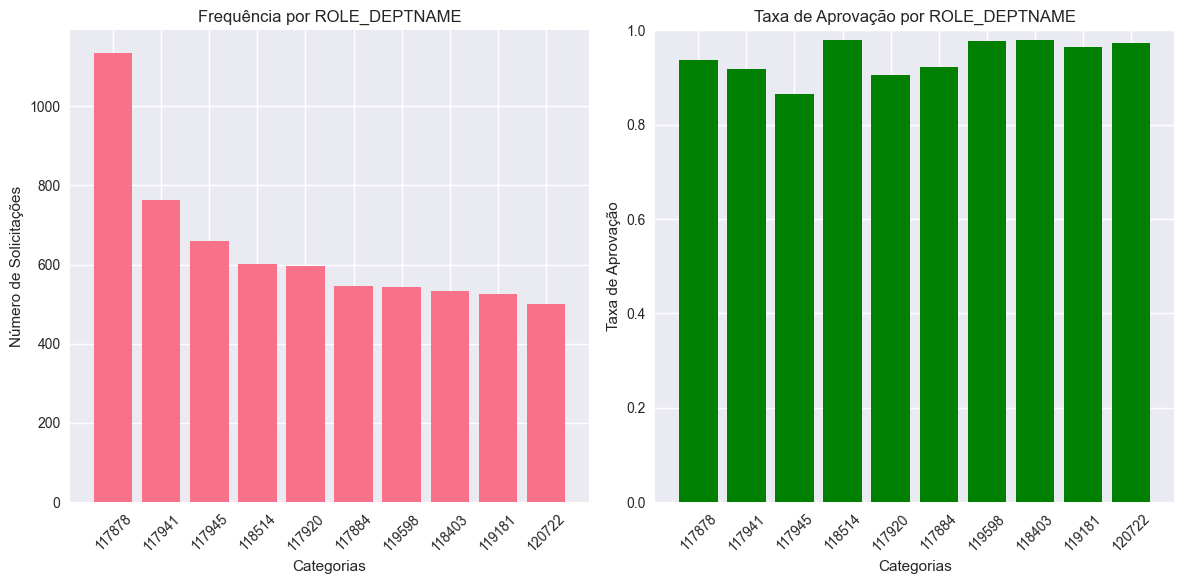


=== ROLE_TITLE ===
Taxa de aprovação por ROLE_TITLE (Top 10 mais frequentes):
  118321.0: 92.0% (4649.0 solicitações)
  117905.0: 96.8% (3583.0 solicitações)
  118784.0: 92.9% (1772.0 solicitações)
  117879.0: 88.9% (1256.0 solicitações)
  118568.0: 92.5% (1043.0 solicitações)
  117885.0: 96.8% (806.0 solicitações)
  118054.0: 97.0% (774.0 solicitações)
  118685.0: 97.5% (597.0 solicitações)
  118777.0: 91.5% (566.0 solicitações)
  118451.0: 96.7% (521.0 solicitações)


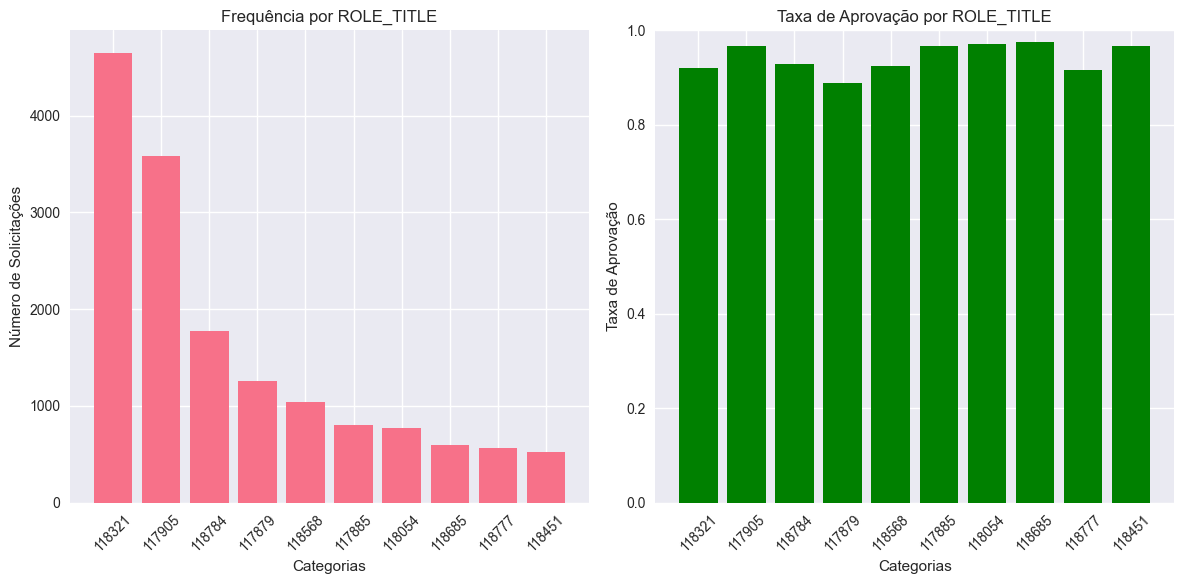


=== ROLE_FAMILY ===
Taxa de aprovação por ROLE_FAMILY (Top 10 mais frequentes):
  290919.0: 94.2% (10980.0 solicitações)
  118424.0: 97.2% (2690.0 solicitações)
  19721.0: 90.8% (2636.0 solicitações)
  117887.0: 95.9% (2400.0 solicitações)
  292795.0: 86.3% (1318.0 solicitações)
  118398.0: 95.2% (1294.0 solicitações)
  308574.0: 94.8% (1287.0 solicitações)
  118453.0: 96.6% (941.0 solicitações)
  118331.0: 94.3% (892.0 solicitações)
  118643.0: 97.1% (783.0 solicitações)


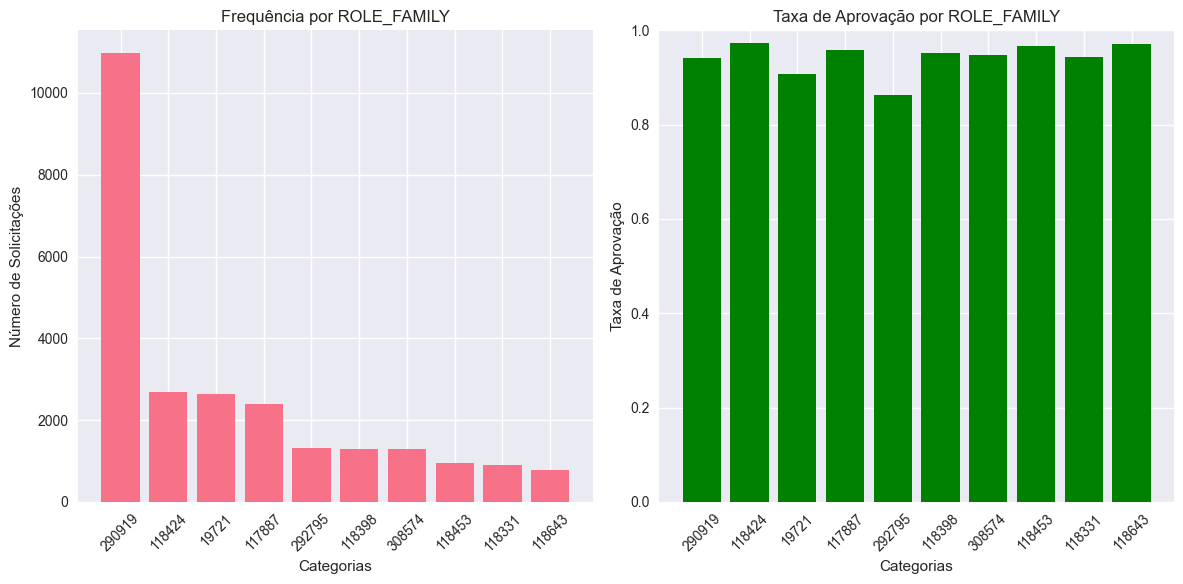

In [16]:
# Análise bivariada - Relação entre variáveis preditoras e target
print("=== ANÁLISE BIVARIADA - VARIÁVEIS vs TARGET ===")

# Função para calcular taxa de aprovação por variável
def analyze_approval_rate(df, var_name, top_n=10):
    """
    Calcula a taxa de aprovação para os top N valores de uma variável
    """
    approval_rates = df.groupby(var_name)['ACTION'].agg(['count', 'mean']).reset_index()
    approval_rates.columns = [var_name, 'total_requests', 'approval_rate']
    approval_rates = approval_rates.sort_values('total_requests', ascending=False).head(top_n)
    
    return approval_rates

# Análise das variáveis com menor cardinalidade
variables_to_analyze = [var for var in categorical_vars if train_df[var].nunique() <= 500]

for var in variables_to_analyze[:5]:  # Analisar apenas as primeiras 5 variáveis
    print(f"\n=== {var} ===")
    approval_rates = analyze_approval_rate(train_df, var)
    
    print(f"Taxa de aprovação por {var} (Top 10 mais frequentes):")
    for _, row in approval_rates.iterrows():
        print(f"  {row[var]}: {row['approval_rate']:.1%} ({row['total_requests']} solicitações)")
    
    # Visualização
    if len(approval_rates) > 2:
        plt.figure(figsize=(12, 6))
        
        # Gráfico de barras para contagem
        plt.subplot(1, 2, 1)
        plt.bar(range(len(approval_rates)), approval_rates['total_requests'])
        plt.title(f'Frequência por {var}')
        plt.xlabel('Categorias')
        plt.ylabel('Número de Solicitações')
        plt.xticks(range(len(approval_rates)), approval_rates[var], rotation=45)
        
        # Gráfico de barras para taxa de aprovação
        plt.subplot(1, 2, 2)
        colors = ['red' if rate < 0.5 else 'green' for rate in approval_rates['approval_rate']]
        plt.bar(range(len(approval_rates)), approval_rates['approval_rate'], color=colors)
        plt.title(f'Taxa de Aprovação por {var}')
        plt.xlabel('Categorias')
        plt.ylabel('Taxa de Aprovação')
        plt.xticks(range(len(approval_rates)), approval_rates[var], rotation=45)
        plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.show()

### 3.6 Análise Matriz de Correlação

<Axes: >

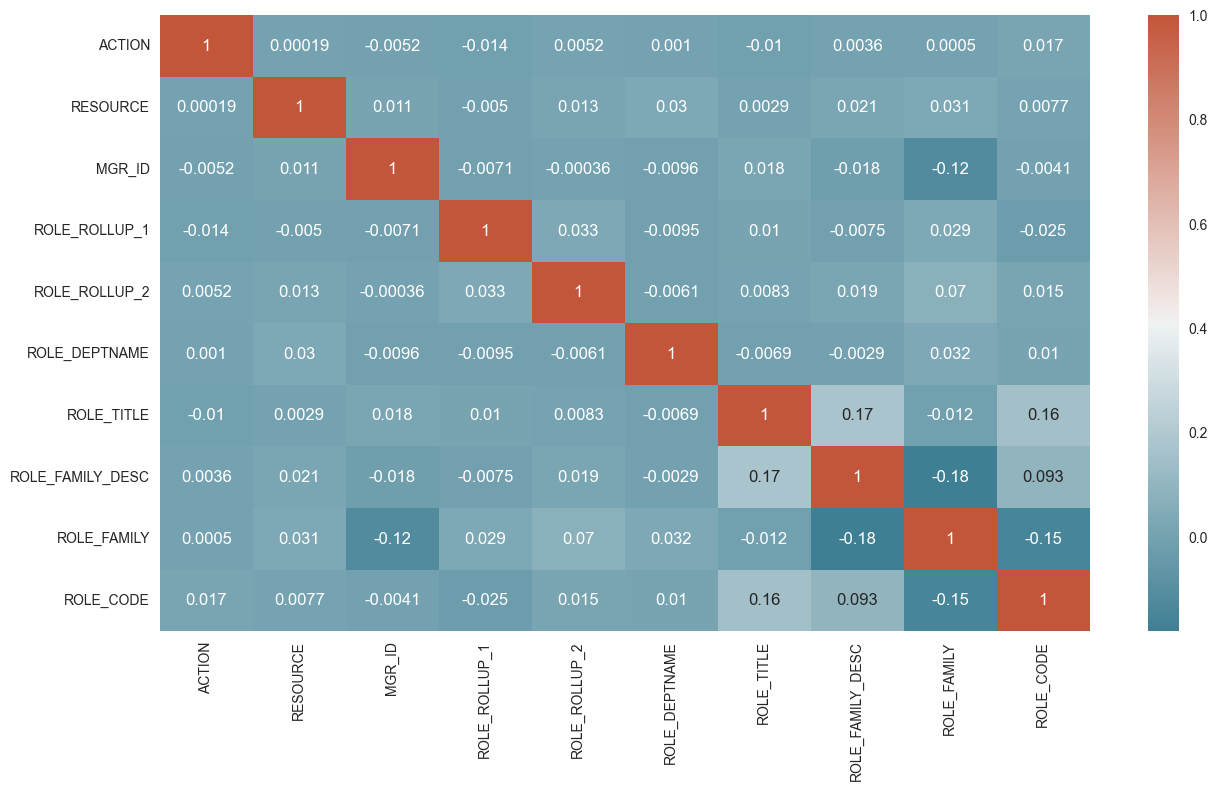

In [31]:
plt.figure(figsize=(15,8))
corr = train_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

### 3.7 Análse da Proporção Por Classe em Cada Feature


ANÁLISE DE CLASSES PARA: RESOURCE

📊 ESTATÍSTICAS GERAIS:
   • Total de categorias: 7518
   • Categorias com < 10 registros: 7009
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 6873

📊 ESTATÍSTICAS GERAIS:
   • Total de categorias: 7518
   • Categorias com < 10 registros: 7009
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 6873


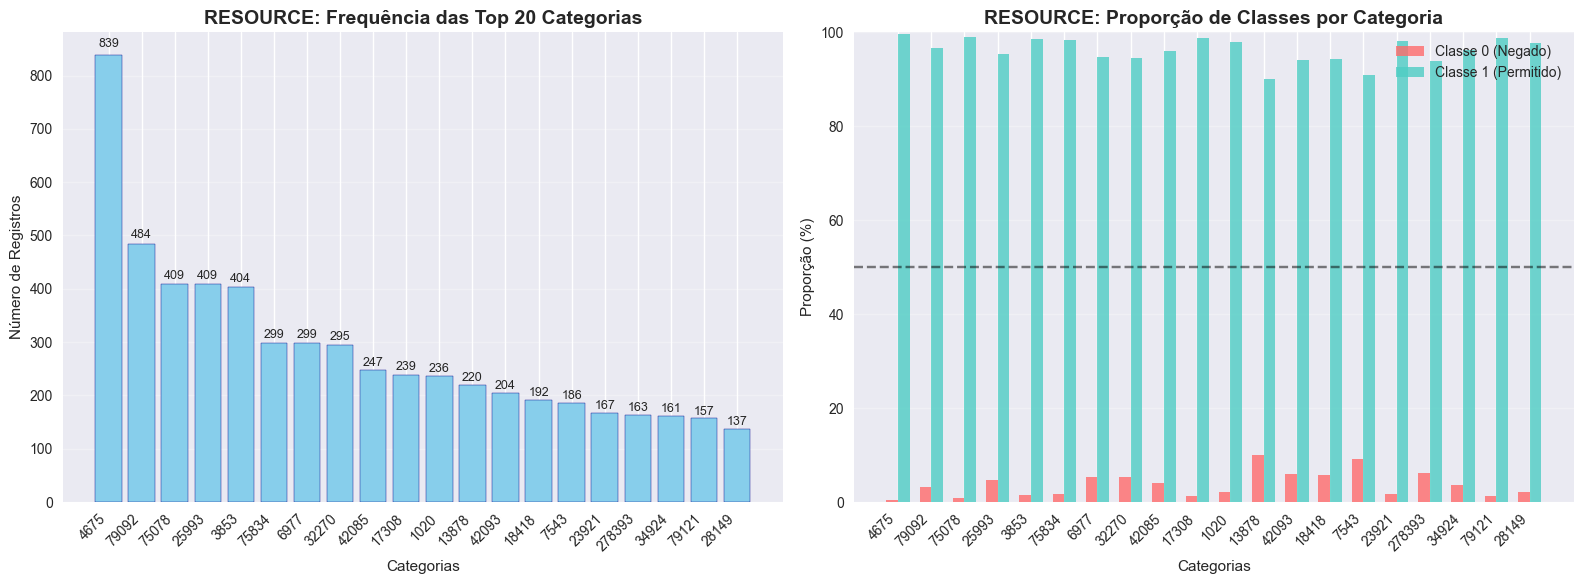


ANÁLISE DE CLASSES PARA: MGR_ID

📊 ESTATÍSTICAS GERAIS:
   • Total de categorias: 4243
   • Categorias com < 10 registros: 3179
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 3705


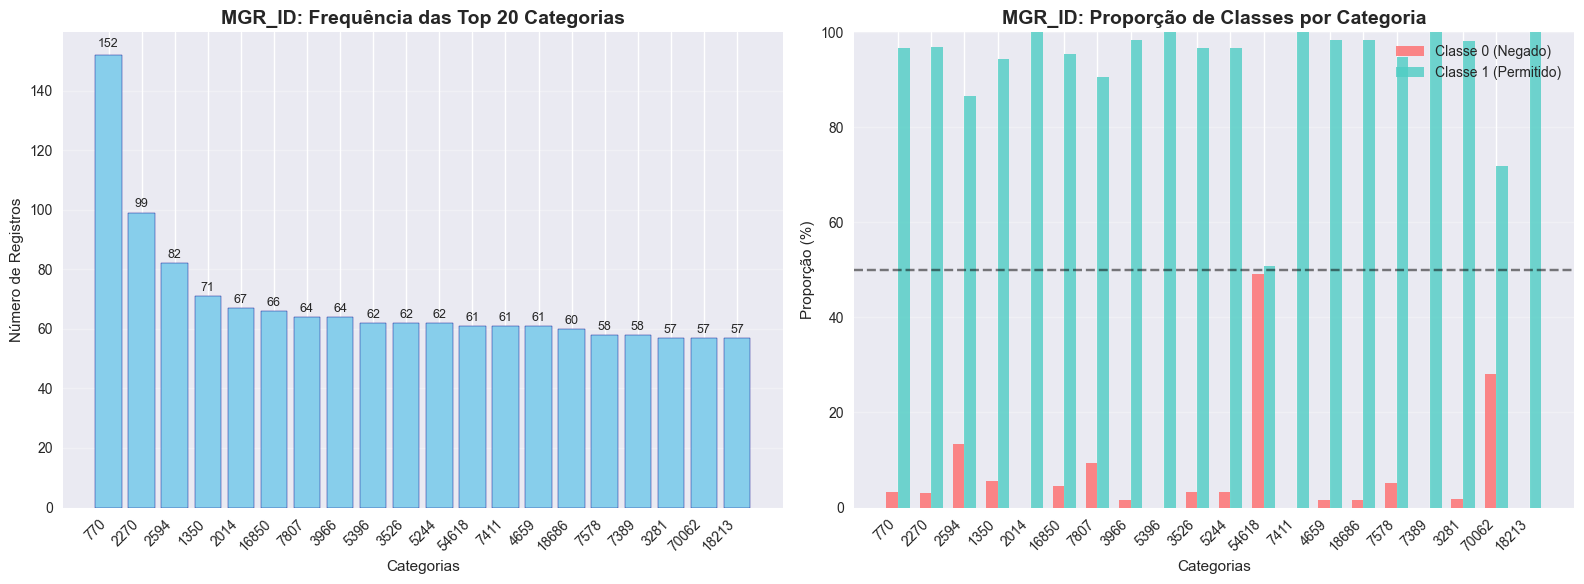


ANÁLISE DE CLASSES PARA: ROLE_ROLLUP_1

📊 ESTATÍSTICAS GERAIS:
   • Total de categorias: 128
   • Categorias com < 10 registros: 23
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 105


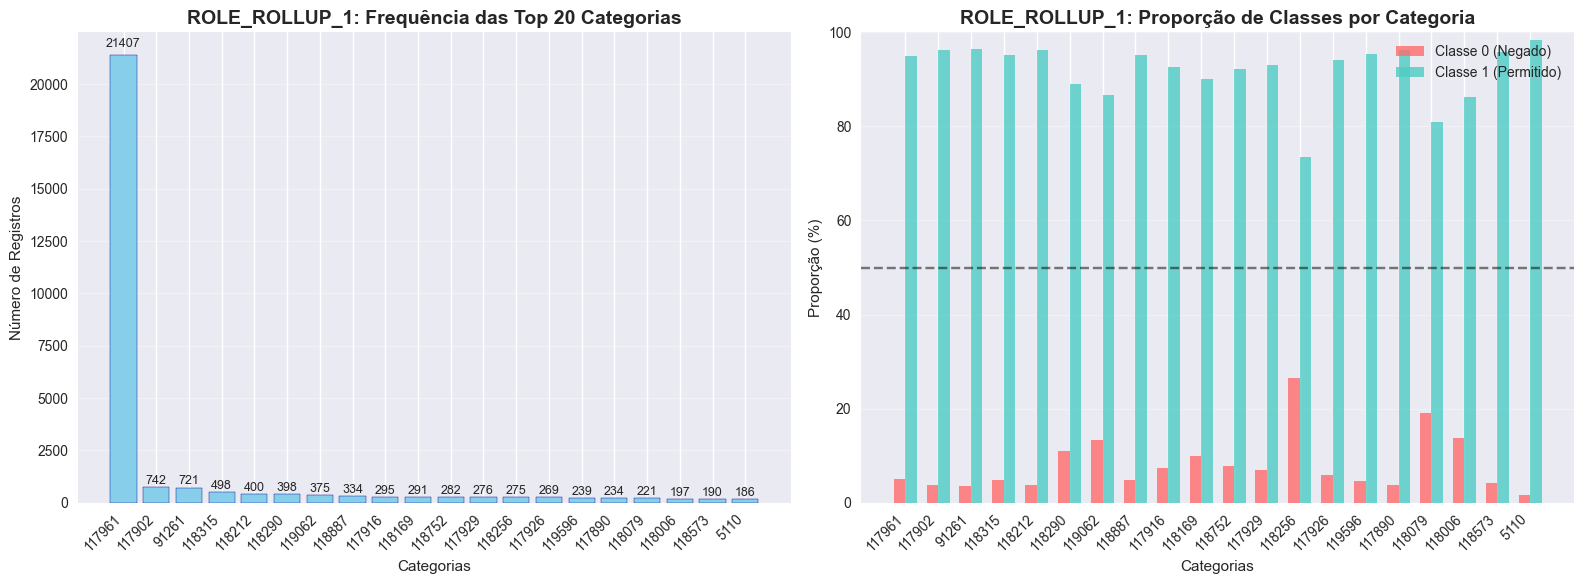


ANÁLISE DE CLASSES PARA: ROLE_ROLLUP_2

📊 ESTATÍSTICAS GERAIS:
   • Total de categorias: 177
   • Categorias com < 10 registros: 43
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 146


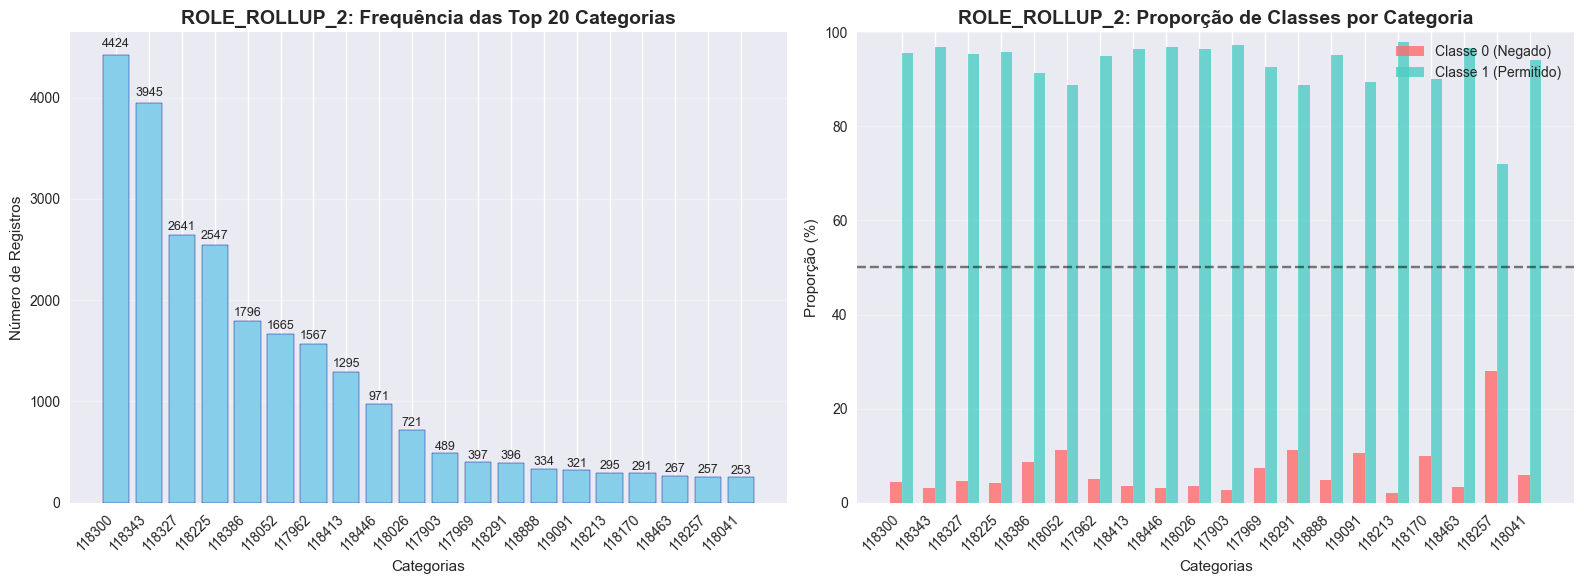


ANÁLISE DE CLASSES PARA: ROLE_DEPTNAME

📊 ESTATÍSTICAS GERAIS:
   • Total de categorias: 449
   • Categorias com < 10 registros: 120
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 358


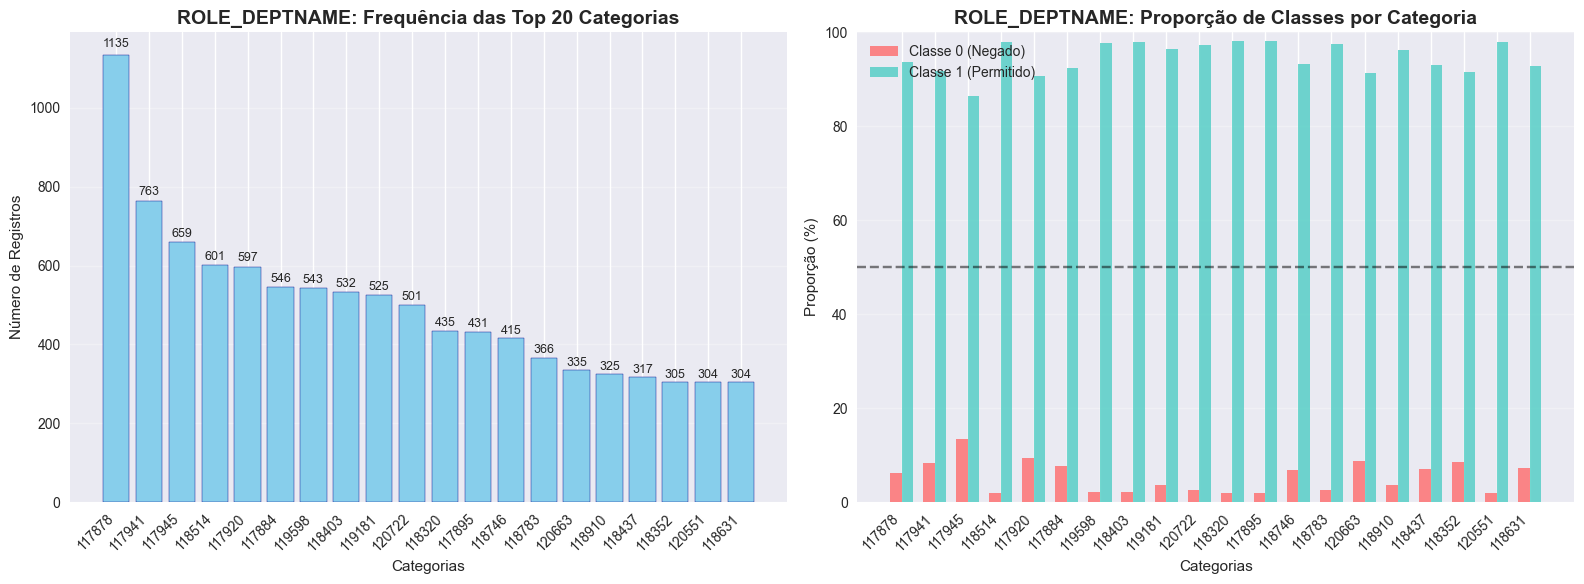


ANÁLISE DE CLASSES PARA: ROLE_TITLE

📊 ESTATÍSTICAS GERAIS:
   • Total de categorias: 343
   • Categorias com < 10 registros: 129
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 293


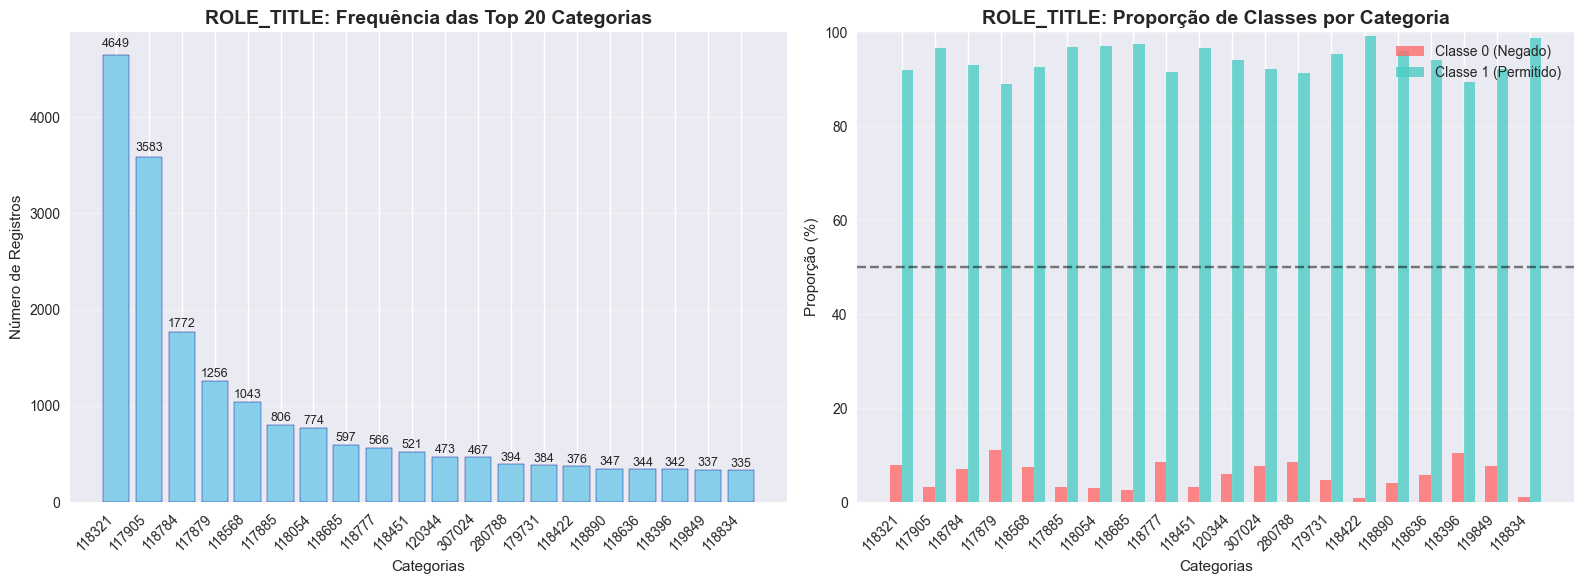


ANÁLISE DE CLASSES PARA: ROLE_FAMILY_DESC

📊 ESTATÍSTICAS GERAIS:
   • Total de categorias: 2358
   • Categorias com < 10 registros: 1889
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 2133


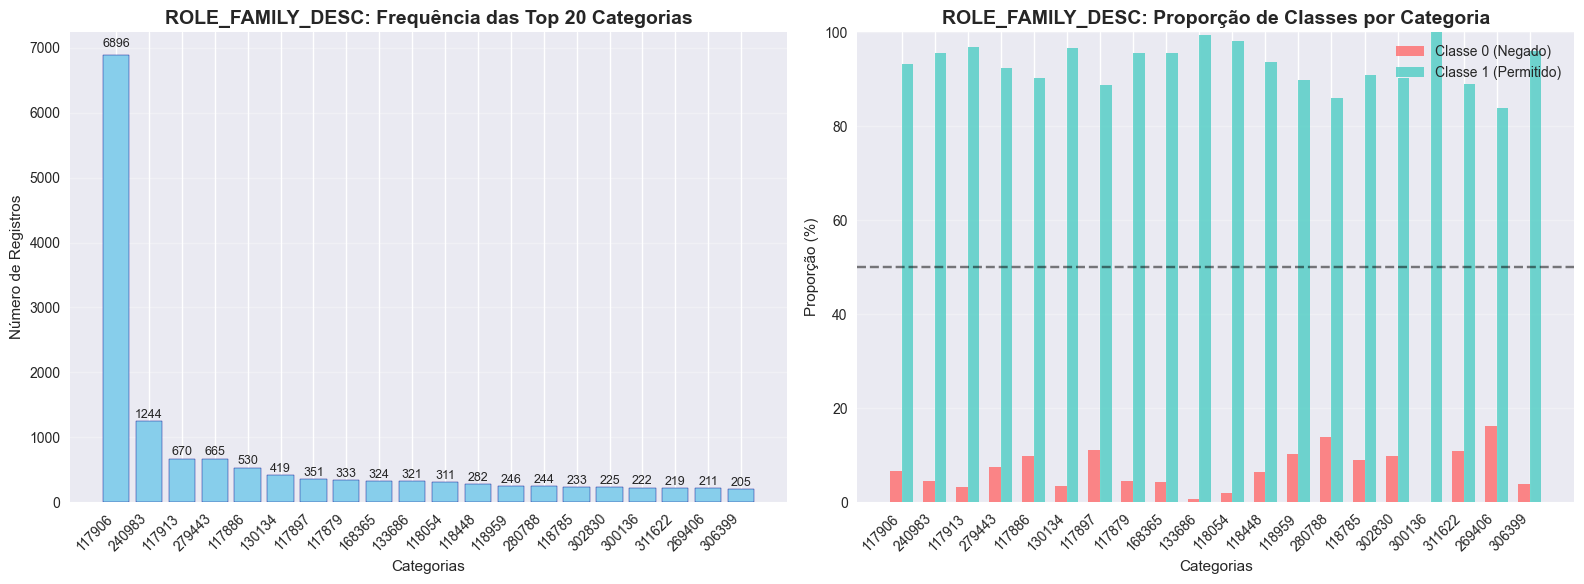


ANÁLISE DE CLASSES PARA: ROLE_FAMILY

📊 ESTATÍSTICAS GERAIS:
   • Total de categorias: 67
   • Categorias com < 10 registros: 17
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 55


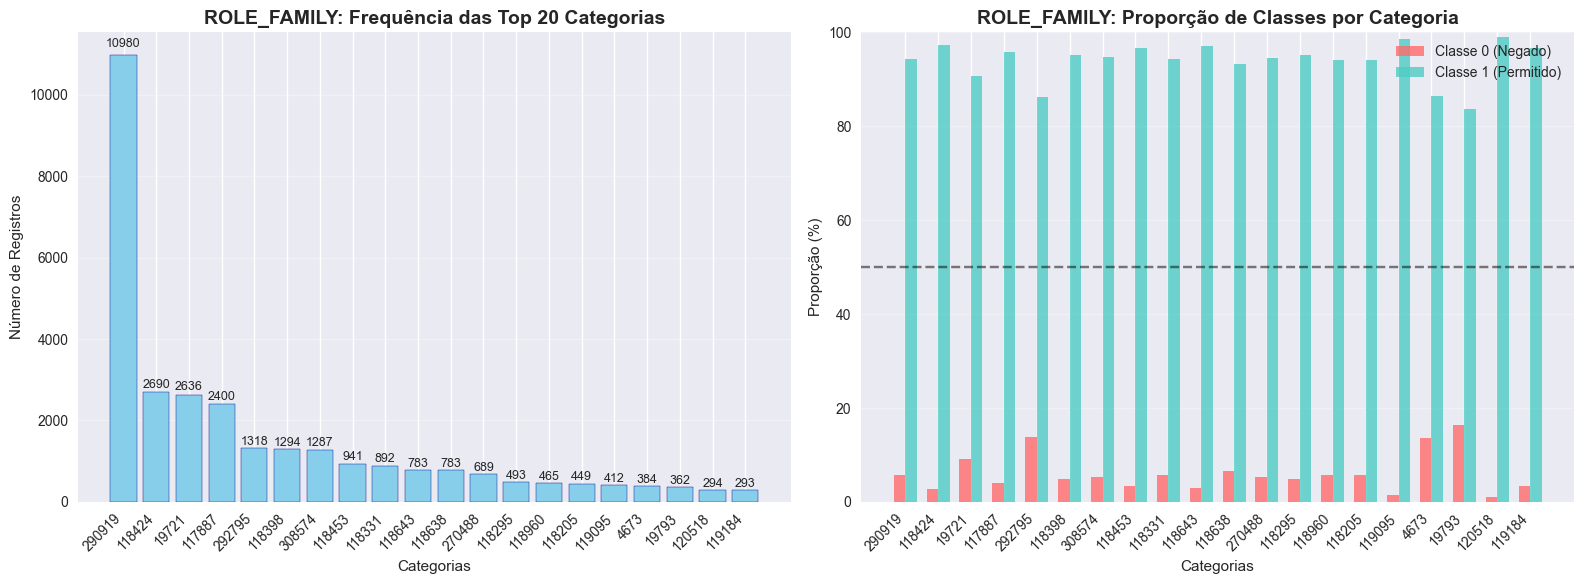


ANÁLISE DE CLASSES PARA: ROLE_CODE

📊 ESTATÍSTICAS GERAIS:
   • Total de categorias: 343
   • Categorias com < 10 registros: 129
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 293


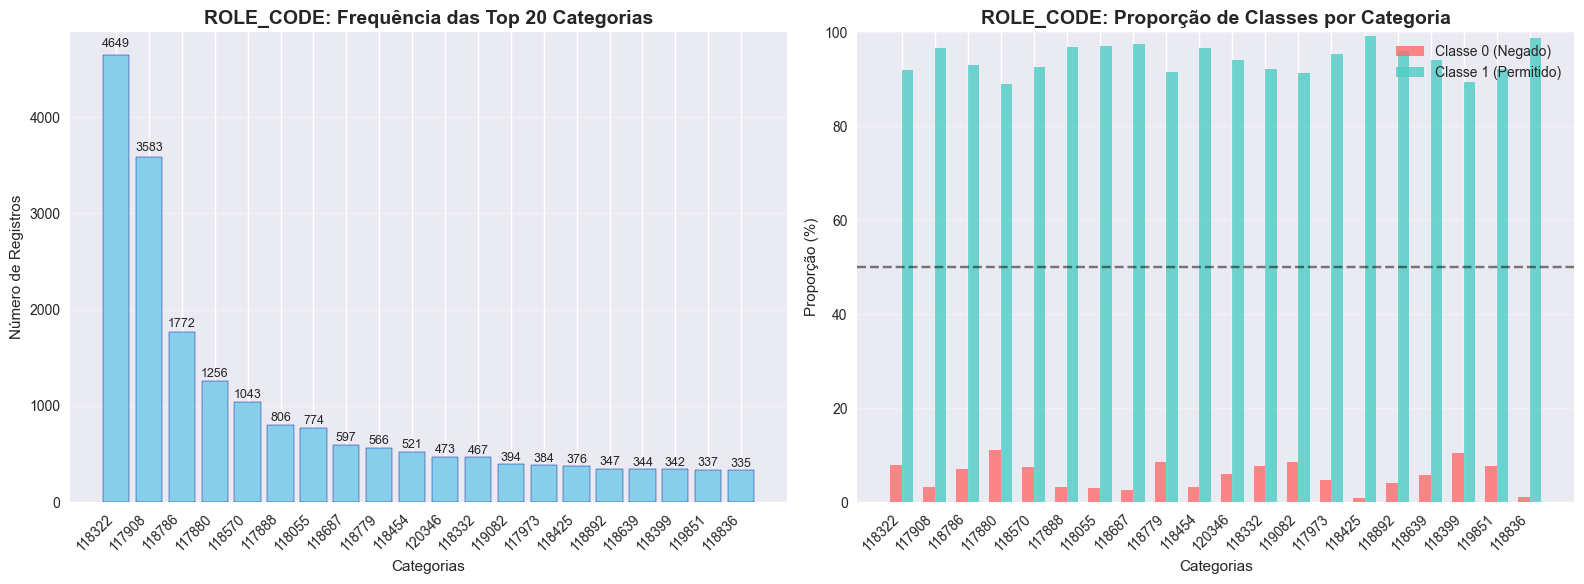


RESUMO CONSOLIDADO

RESUMO POR VARIÁVEL:
Variável        Total    Pouca Repr   %Pouca Repr  Reg Pouca    %Reg Pouca   Desbal   %Desbal 
----------------------------------------------------------------------------------------------------
RESOURCE        7518     7009         93.2         14801        45.17        6873     91.4    
MGR_ID          4243     3179         74.9         10913        33.30        3705     87.3    
ROLE_FAMILY_DESC 2358     1889         80.1         5790         17.67        2133     90.5    
ROLE_TITLE      343      129          37.6         510          1.56         293      85.4    
ROLE_CODE       343      129          37.6         510          1.56         293      85.4    
ROLE_DEPTNAME   449      120          26.7         480          1.46         358      79.7    
ROLE_ROLLUP_2   177      43           24.3         157          0.48         146      82.5    
ROLE_ROLLUP_1   128      23           18.0         75           0.23         105      82.0    
R

In [37]:
def analyze_class_representation(df, col, target_col='ACTION', min_samples=10):
    """
    Analisa a representação de classes dentro de cada categoria
    """
    # Crosstab para ver distribuição de classes por categoria
    crosstab = pd.crosstab(df[col], df[target_col], margins=True)
    
    # Calcular proporções - só para categorias, não para o total
    props = pd.crosstab(df[col], df[target_col], normalize='index') * 100
    
    # Garantir que temos ambas as classes (0 e 1) no crosstab
    if 0 not in crosstab.columns:
        crosstab = crosstab.copy()
        crosstab[0] = 0
    if 1 not in crosstab.columns:
        crosstab = crosstab.copy()
        crosstab[1] = 0
    
    # Garantir que temos ambas as classes (0 e 1) no props
    if 0 not in props.columns:
        props = props.copy()
        props[0] = 0.0
    if 1 not in props.columns:
        props = props.copy()
        props[1] = 0.0
    
    # Reordenar colunas para garantir ordem consistente
    crosstab = crosstab[[0, 1, 'All']]
    props = props[[0, 1]]
    
    # Remover a linha 'All' do crosstab e props
    crosstab_categories = crosstab.drop('All', axis=0)
    props_categories = props.drop('All', axis=0) if 'All' in props.index else props
    
    # Garantir que ambos têm o mesmo índice
    common_index = crosstab_categories.index.intersection(props_categories.index)
    crosstab_categories = crosstab_categories.loc[common_index]
    props_categories = props_categories.loc[common_index]
    
    # Combinar contagem e proporções
    analysis = pd.DataFrame({
        'categoria': common_index,
        'total_registros': crosstab_categories['All'].values,
        'classe_0_count': crosstab_categories[0].values,
        'classe_1_count': crosstab_categories[1].values,
        'classe_0_prop': props_categories[0].values,
        'classe_1_prop': props_categories[1].values
    })
    
    # Identificar categorias com pouca representação
    low_representation = analysis[analysis['total_registros'] < min_samples]
    
    # Identificar categorias com classes desbalanceadas
    imbalanced = analysis[
        (analysis['classe_0_prop'] < 10) | (analysis['classe_0_prop'] > 90)
    ]
    
    return analysis, low_representation, imbalanced

# Análise para cada variável categórica
categorical_analysis = {}
for col in categorical_vars:  # Todas as variáveis categóricas
    print(f"\n{'='*60}")
    print(f"ANÁLISE DE CLASSES PARA: {col}")
    print(f"{'='*60}")
    
    analysis, low_rep, imbalanced = analyze_class_representation(train_df, col)
    categorical_analysis[col] = {
        'analysis': analysis,
        'low_representation': low_rep,
        'imbalanced': imbalanced
    }
    
    # Estatísticas gerais (simplificadas)
    print(f"\n📊 ESTATÍSTICAS GERAIS:")
    print(f"   • Total de categorias: {len(analysis)}")
    print(f"   • Categorias com < 10 registros: {len(low_rep)}")
    print(f"   • Categorias desbalanceadas (>90% ou <10% de uma classe): {len(imbalanced)}")
    
    # Visualização - Top 20 categorias mais frequentes
    top_20 = analysis.sort_values('total_registros', ascending=False).head(20)
    
    # Criar gráficos lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico 1: Frequência das categorias
    ax1 = axes[0]
    bars = ax1.bar(range(len(top_20)), top_20['total_registros'], color='skyblue', edgecolor='darkblue')
    ax1.set_title(f'{col}: Frequência das Top 20 Categorias', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Categorias')
    ax1.set_ylabel('Número de Registros')
    ax1.set_xticks(range(len(top_20)))
    ax1.set_xticklabels([str(x) for x in top_20['categoria']], rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Gráfico 2: Proporção de classes por categoria
    ax2 = axes[1]
    width = 0.35
    x = np.arange(len(top_20))
    
    bars1 = ax2.bar(x - width/2, top_20['classe_0_prop'], width, 
                   label='Classe 0 (Negado)', color='#FF6B6B', alpha=0.8)
    bars2 = ax2.bar(x + width/2, top_20['classe_1_prop'], width, 
                   label='Classe 1 (Permitido)', color='#4ECDC4', alpha=0.8)
    
    ax2.set_title(f'{col}: Proporção de Classes por Categoria', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Categorias')
    ax2.set_ylabel('Proporção (%)')
    ax2.set_xticks(x)
    ax2.set_xticklabels([str(x) for x in top_20['categoria']], rotation=45, ha='right')
    ax2.legend()
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    
    # Adicionar linha de referência em 50%
    ax2.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='Balanceamento (50%)')
    
    plt.tight_layout()
    plt.show()

# Criar resumo consolidado
print(f"\n{'='*60}")
print("RESUMO CONSOLIDADO")
print(f"{'='*60}")

summary_data = []
for var, data in categorical_analysis.items():
    analysis = data['analysis']
    low_rep = data['low_representation']
    imbalanced = data['imbalanced']
    
    summary_data.append({
        'variavel': var,
        'total_categorias': len(analysis),
        'categorias_pouca_repr': len(low_rep),
        'perc_pouca_repr': (len(low_rep) / len(analysis)) * 100,
        'registros_pouca_repr': low_rep['total_registros'].sum(),
        'perc_registros_pouca_repr': (low_rep['total_registros'].sum() / len(train_df)) * 100,
        'categorias_desbalanceadas': len(imbalanced),
        'perc_desbalanceadas': (len(imbalanced) / len(analysis)) * 100
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('perc_registros_pouca_repr', ascending=False)

print("\nRESUMO POR VARIÁVEL:")
print(f"{'Variável':<15} {'Total':<8} {'Pouca Repr':<12} {'%Pouca Repr':<12} {'Reg Pouca':<12} {'%Reg Pouca':<12} {'Desbal':<8} {'%Desbal':<8}")
print("-" * 100)
for _, row in summary_df.iterrows():
    print(f"{row['variavel']:<15} {row['total_categorias']:<8} "
          f"{row['categorias_pouca_repr']:<12} {row['perc_pouca_repr']:<12.1f} "
          f"{row['registros_pouca_repr']:<12} {row['perc_registros_pouca_repr']:<12.2f} "
          f"{row['categorias_desbalanceadas']:<8} {row['perc_desbalanceadas']:<8.1f}")